<a href="https://colab.research.google.com/github/Wahibasa/Modele--Profond-Unet--CIFAR10-/blob/main/Modele_Profond(Unet)_CIFAR10_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Préparation des données et ajout de bruit Poivre & Sel

- Chargement du dataset **CIFAR-10** (images couleur 32×32).  
- Normalisation des pixels entre 0 et 1 pour améliorer la stabilité de l’entraînement.  
- Séparation du jeu d’entraînement et de validation (10% pour validation).  
- Ajout d’un **bruit Poivre & Sel** (20%) aux images d’entraînement, de validation et de test.  

- Mise en place d’une **data augmentation symétrique** avec retournement horizontal aléatoire.  


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.datasets import cifar10
from skimage.metrics import peak_signal_noise_ratio as psnr_score
from skimage.metrics import structural_similarity as ssim_score
import random

# =====================================================
# 1. PRÉPARATION ET BRUIT POIVRE ET SEL
# =====================================================
(x_train_full, _), (x_test, _) = cifar10.load_data()
x_train_full = x_train_full.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

val_size = int(len(x_train_full) * 0.1)
x_train = x_train_full[val_size:]
x_val = x_train_full[:val_size]

def add_salt_and_pepper_noise(image, amount=0.2):
    """Ajoute du bruit Poivre et Sel à une image."""
    noisy_img = np.copy(image)
    # Sel (pixels blancs)
    num_salt = np.ceil(amount * image.size * 0.5)
    coords = [np.random.randint(0, i - 1, int(num_salt)) for i in image.shape]
    noisy_img[tuple(coords)] = 1.0
    # Poivre (pixels noirs)
    num_pepper = np.ceil(amount * image.size * 0.5)
    coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in image.shape]
    noisy_img[tuple(coords)] = 0.0
    return noisy_img

# Appliquer le nouveau bruit avec amount=0.2 (20%)
x_train_noisy = np.array([add_salt_and_pepper_noise(img, amount=0.2) for img in x_train])
x_val_noisy = np.array([add_salt_and_pepper_noise(img, amount=0.2) for img in x_val])
x_test_noisy = np.array([add_salt_and_pepper_noise(img, amount=0.2) for img in x_test])

# Data Augmentation Symétrique
def augment(noisy, clean):
    combined = tf.concat([noisy, clean], axis=-1)
    combined = tf.image.random_flip_left_right(combined)
    return combined[..., :3], combined[..., 3:]

train_ds = tf.data.Dataset.from_tensor_slices((x_train_noisy, x_train))
train_ds = train_ds.shuffle(1000).batch(64).map(augment).prefetch(tf.data.AUTOTUNE)


##  Architecture U-Net pour le débruitage

- Basée sur **U-Net**, adaptée aux images couleur 32×32 (CIFAR-10).  
- **Encodeur ** : 3 couches principales (Conv2D + MaxPooling2D) pour extraire les caractéristiques, avec une **couche cible** pour Grad-CAM.  
- **Bottleneck** : 1 couche Conv2D centrale pour la compression des informations.  
- **Décodeur ** : 4 couches principales (UpSampling2D + concatenation + Conv2D) pour reconstruire l’image originale.  
- Activation finale **Sigmoid** pour obtenir des pixels entre 0 et 1.  
- Compilation :  
  - Optimiseur : **AdamW (lr=0.0005)**  
  - Loss : **MSE**  
  - Métrique : **SSIM**  


In [ ]:
# =====================================================
# 2. ARCHITECTURE U-NET
# =====================================================
input_img = layers.Input(shape=(32, 32, 3))
c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
p1 = layers.MaxPooling2D((2, 2))(c1)
c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same', name="target_layer")(p1)
p2 = layers.MaxPooling2D((2, 2))(c2)
b = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
u1 = layers.UpSampling2D((2, 2))(b)
concat1 = layers.Concatenate()([u1, c2])
c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(concat1)
u2 = layers.UpSampling2D((2, 2))(c3)
concat2 = layers.Concatenate()([u2, c1])
c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(concat2)
decoded = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(c4)

autoencoder = models.Model(input_img, decoded)
def ssim_metric(y_true, y_pred):
    return tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))

autoencoder.compile(optimizer=optimizers.AdamW(0.0005), loss='mse', metrics=[ssim_metric])
autoencoder.summary()


##  Entraînement du modèle et Grad-CAM

- Le modèle **U-Net** est entraîné sur les images bruitées avec **20 epochs** et validation sur les images bruitées de validation.  
- **Loss utilisée** : MSE (Erreur quadratique moyenne) pour comparer les images reconstruites aux images originales.  
- **Métrique utilisée** : SSIM pour mesurer la similarité structurelle des images reconstruites.  
- **Grad-CAM** : méthode pour visualiser quelles zones de l’image influencent le modèle pendant la reconstruction.  
  - Utilise la **couche cible** de l’encodeur (`target_layer`).  
  - Génère une **carte de chaleur** montrant les parties les plus importantes pour le débruitage.  


In [ ]:
# =====================================================
# 3. ENTRAÎNEMENT ET GRAD-CAM
# =====================================================
history = autoencoder.fit(train_ds, epochs=20, validation_data=(x_val_noisy, x_val))

def make_gradcam(img, model, layer_name):
    grad_model = models.Model([model.inputs], [model.get_layer(layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, preds = grad_model(np.array([img]))
        loss = tf.reduce_mean(preds)
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    heatmap = conv_outputs[0] @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / (tf.math.reduce_max(heatmap) + 1e-8)
    return heatmap.numpy()

## Évaluation et résultats finaux

- Le modèle **U-Net** est évalué sur les jeux de données : **Train, Validation et Test**.  
- **Métriques calculées** :  
  - **MSE (Erreur quadratique moyenne)** : mesure l’écart moyen entre les images originales et reconstruites.  
  - **PSNR (Peak Signal-to-Noise Ratio)** : mesure la qualité de reconstruction en termes de rapport signal/bruit.  
  - **SSIM (Structural Similarity Index)** : mesure la similarité perceptuelle entre les images originales et reconstruites.  
- Les résultats sont affichés sous forme de tableau pour comparer les performances du modèle sur chaque dataset.  


In [ ]:
# =====================================================
# 4. RÉSULTATS FINAUX
# =====================================================
def get_scores(noisy, clean, name):
    p = autoencoder.predict(noisy, verbose=0)
    mse = np.mean((clean - p)**2)
    psnr = np.mean([psnr_score(clean[i], p[i], data_range=1.0) for i in range(len(clean))])
    ssim = np.mean([ssim_score(clean[i], p[i], data_range=1.0, channel_axis=-1) for i in range(len(clean))])
    return [name, mse, psnr, ssim]

res = [get_scores(x_train_noisy[:1000], x_train[:1000], "Train"),
       get_scores(x_val_noisy, x_val, "Validation"),
       get_scores(x_test_noisy, x_test, "Test")]

print("\n" + "="*70)
print(f"{'Dataset':<15} | {'MSE (↓)':<12} | {'PSNR (↑)':<12} | {'SSIM (↑)':<12}")
print("-" * 70)
for r in res:
    print(f"{r[0]:<15} | {r[1]:.6f}     | {r[2]:.2f}        | {r[3]:.4f}")
print("="*70)

##  Affichage des courbes d’apprentissage (MSE & SSIM)

- Visualisation de l’évolution de la **perte (MSE)** pour l’entraînement et la validation au fil des epochs.  
- Visualisation de l’évolution de la **métrique SSIM** pour l’entraînement et la validation.  


In [ ]:
# =====================================================
# 5. AFFICHAGE DES COURBES D'APPRENTISSAGE (MSE & SSIM)
# =====================================================
plt.figure(figsize=(16, 5))

# Graphique MSE
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train MSE', color='blue', lw=2)
plt.plot(history.history['val_loss'], label='Val MSE', color='orange', lw=2)
plt.title('Évolution de la Perte (MSE)')
plt.xlabel('Époques')
plt.ylabel('Erreur')
plt.legend()
plt.grid(True, alpha=0.3)

# Graphique SSIM
plt.subplot(1, 2, 2)
plt.plot(history.history['ssim_metric'], label='Train SSIM', color='green', lw=2)
plt.plot(history.history['val_ssim_metric'], label='Val SSIM', color='red', lw=2)
plt.title('Évolution de la Similarité (SSIM)')
plt.xlabel('Époques')
plt.ylabel('Score SSIM')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

##  Affichage des résultats visuels et Grad-CAM

- Sélection aléatoire de **5 images** du jeu de test pour visualisation.  
- Affichage de chaque image sous 4 formes :  
  1. **Image originale**  
  2. **Image bruitée** (Poivre et Sel 20%)  
  3. **Focus Grad-CAM** : superposition de la carte de chaleur montrant où le modèle se concentre pour la reconstruction.  
  4. **Image reconstruite** par l’autoencodeur (débruitée).  
- Pour faire une *comparaison visuelle** de l’efficacité du débruitage et de comprendre **quelles zones influencent le modèle**.  
- Pour une **analyse qualitative** complémentaire aux métriques numériques (MSE, PSNR, SSIM).

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 32, 32,    │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 16, 16,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ target_layer        │ (None, 16, 16,    │     73,856 │ max_pooling2d[0]… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 8, 8, 128) │          0 │ target_layer[0][… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 8, 8, 256) │    295,168 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 16, 16,    │          0 │ conv2d_1[0][0]    │
│ (UpSampling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 16, 16,    │          0 │ up_sampling2d[0]… │
│ (Concatenate)       │ 384)              │            │ target_layer[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 16, 16,    │    442,496 │ concatenate[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_1     │ (None, 32, 32,    │          0 │ conv2d_2[0][0]    │
│ (UpSampling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 32, 32,    │          0 │ up_sampling2d_1[… │
│ (Concatenate)       │ 192)              │            │ conv2d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 32, 32,    │    110,656 │ concatenate_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32, 3) │      1,731 │ conv2d_3[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 925,699 (3.53 MB)

 Trainable params: 925,699 (3.53 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 31s 31ms/step - loss: 0.0117 - ssim_metric: 0.7276 - val_loss: 0.0025 - val_ssim_metric: 0.9091
Epoch 2/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - loss: 0.0023 - ssim_metric: 0.9148 - val_loss: 0.0020 - val_ssim_metric: 0.9250
Epoch 3/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 17s 24ms/step - loss: 0.0019 - ssim_metric: 0.9283 - val_loss: 0.0018 - val_ssim_metric: 0.9333
Epoch 4/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - loss: 0.0017 - ssim_metric: 0.9356 - val_loss: 0.0022 - val_ssim_metric: 0.9350
Epoch 5/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 17s 24ms/step - loss: 0.0015 - ssim_metric: 0.9414 - val_loss: 0.0014 - val_ssim_metric: 0.9457
Epoch 6/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - loss: 0.0013 - ssim_metric: 0.9481 - val_loss: 0.0011 - val_ssim_metric: 0.9511
Epoch 7/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - loss: 0.0011 - ssim_metric: 0.9538 - val_loss: 0.0011 - val_ssim_metric: 0.9568
Epoch 8/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms

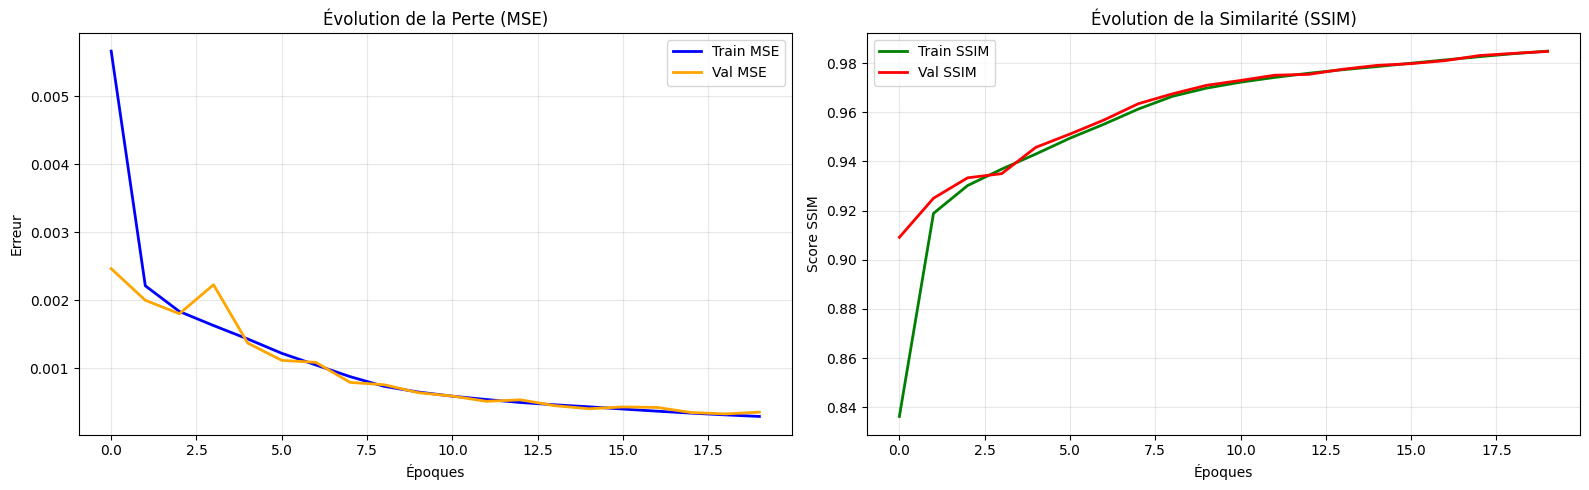

/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor']]
Received: inputs=Tensor(shape=(1, 32, 32, 3))
  warnings.warn(msg)


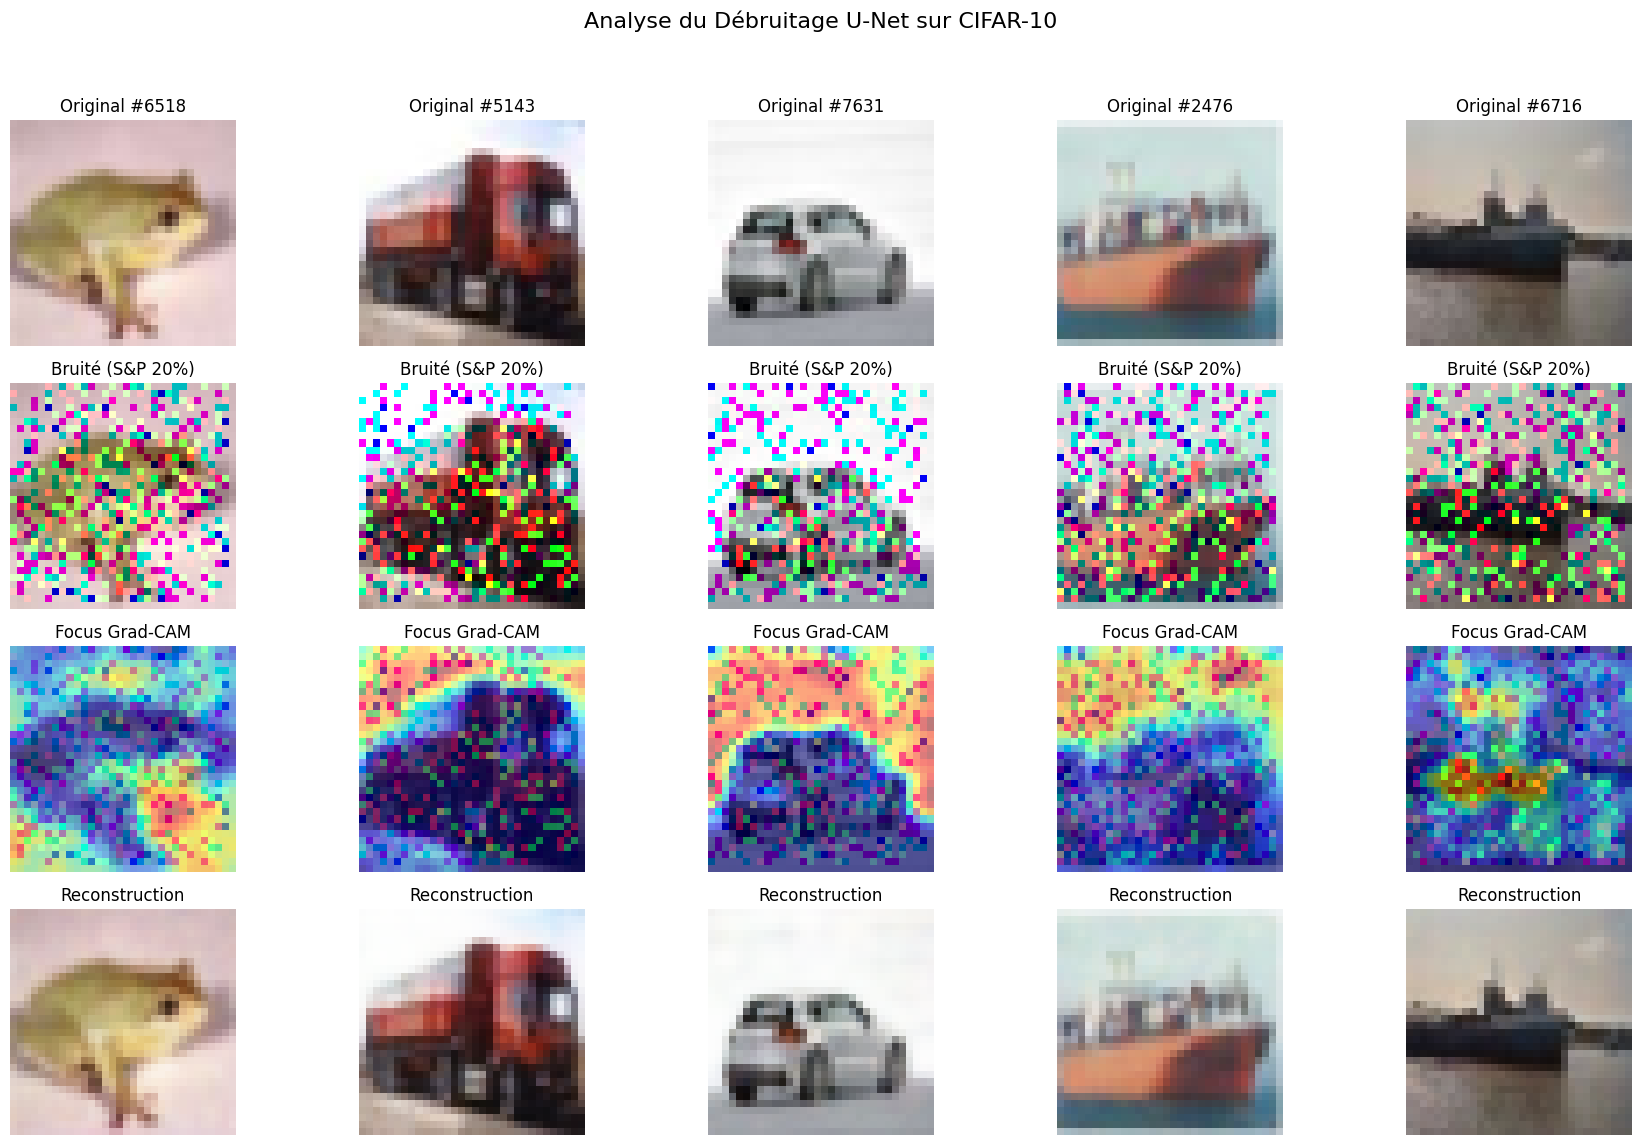

In [ ]:


# =====================================================
# 6. AFFICHAGE DES RÉSULTATS VISUELS ET GRAD-CAM
# =====================================================
n = 5  # Nombre d'images à afficher
indices = random.sample(range(len(x_test)), n)
preds = autoencoder.predict(x_test_noisy[indices], verbose=0)

plt.figure(figsize=(18, 12))
for i, idx in enumerate(indices):
    # Calcul de la Heatmap Grad-CAM
    img_input = x_test_noisy[idx:idx+1]
    heatmap = make_gradcam(img_input[0], autoencoder, "target_layer")

    # Redimensionnement de la heatmap pour superposition
    heatmap_rescaled = tf.image.resize(heatmap[..., np.newaxis], (32, 32)).numpy().squeeze()

    # 1. Image Originale
    ax = plt.subplot(4, n, i + 1)
    plt.imshow(x_test[idx])
    plt.title(f"Original #{idx}")
    plt.axis("off")

    # 2. Image Bruitée (Poivre et Sel)
    ax = plt.subplot(4, n, i + 1 + n)
    plt.imshow(x_test_noisy[idx])
    plt.title("Bruité (S&P 20%)")
    plt.axis("off")

    # 3. Visualisation Grad-CAM (Où l'IA regarde)
    ax = plt.subplot(4, n, i + 1 + 2*n)
    plt.imshow(x_test_noisy[idx])
    plt.imshow(heatmap_rescaled, cmap='jet', alpha=0.5) # Superposition
    plt.title("Focus Grad-CAM")
    plt.axis("off")

    # 4. Image Reconstruite (Débruitée)
    ax = plt.subplot(4, n, i + 1 + 3*n)
    plt.imshow(preds[i])
    plt.title("Reconstruction")
    plt.axis("off")

plt.suptitle("Analyse du Débruitage U-Net sur CIFAR-10", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()